Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


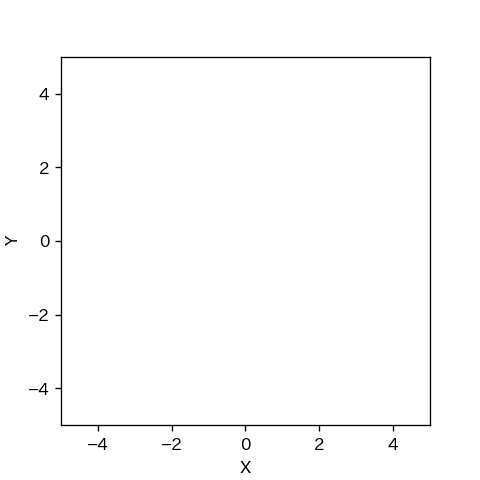

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom_trap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


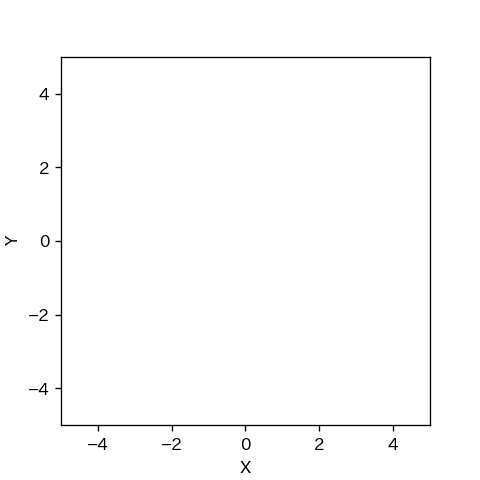

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_phantom_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [0.19609083 2.54581758 3.09272038] 推定値: [-0.7773005   3.28333465  3.53702595] 誤差: 1.221237948115905
1 真値: [-1.9022404   1.49721635  4.44217843] 推定値: [-1.30807315  2.16529847  4.22444916] 誤差: 0.8940740721001114
1
2 真値: [0.7407076  2.0265592  2.33430796] 推定値: [0.90152767 1.91522546 2.27061831] 誤差: 0.19559728727416023
2
3 真値: [0.07776155 2.56482928 3.15247816] 推定値: [-0.46366506  2.79576131  3.33373851] 誤差: 0.5886190466810711
3
4 真値: [1.47540836 1.92367806 1.87149468] 推定値: [1.48243233 2.54891072 2.37280612] 誤差: 0.6252721182022203
4
5 真値: [0.31187619 2.0870198  2.96915346] 推定値: [0.60848279 1.70881423 2.8512205 ] 誤差: 0.4806401155451642
5
6 真値: [0.45959252 2.15483843 3.01007352] 推定値: [-0.10499544  2.32978476  3.03020875] 誤差: 0.5910717282390738
6
7 真値: [1.06057098 2.13504373 2.36908339] 推定値: [-0.02416008  0.87647031  5.66434067] 誤差: 1.6615199495379123
8 真値: [1.53474435 1.49056851 1.71415118] 推定値: [1.27789728 1.84120598 1.46707072] 誤差: 0.4346459051534794
7
9 真値: [-0.36182018  1.60076275  

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [0.47693159 2.3541212  2.93370226] 推定値: [0.72392125 2.24611733 2.84564397] 誤差: 0.26957138876207953
16
21 真値: [-0.46592977  1.87656551  3.93939617] 推定値: [-1.46044179  2.32766822  4.08794201] 誤差: 1.0920383751433083
22 真値: [-0.25986574  1.65365267  3.68871619] 推定値: [0.23143035 1.63426897 3.66189325] 誤差: 0.4916783169754505
17
23 真値: [-0.18927553  1.54052151  3.75328252] 推定値: [-0.12339024  2.2037909   3.81554863] 誤差: 0.6665336872391541
18
24 真値: [-1.32904655  2.12084224  4.31609064] 推定値: [-1.3293629   2.85535128  4.5764633 ] 誤差: 0.7345091029978306
19
25 真値: [0.40002715 2.12485259 2.77919868] 推定値: [-0.31820706  3.85158974  3.08654117] 誤差: 1.870155490536947
26 真値: [-0.20941813  2.39894104  3.1409048 ] 推定値: [-0.7692102   1.86430834  2.98635471] 誤差: 0.7740796327100785
20
27 真値: [0.23174859 2.06297717 3.01302031] 推定値: [-0.87231257  2.68684099  3.21061735] 誤差: 1.2681313459530894
28 真値: [-0.65962746  2.01750691  3.73169142] 推定値: [-0.40051585  1.82194822  3.78566331] 誤差: 0.3246259836828836
2